In [ ]:
import asyncio
import streamlit as st
from typing import TypedDict, List, Dict, Any
from streamlit.runtime.uploaded_file_manager import UploadedFile

from langgraph.graph import StateGraph, END
from langchain_core.runnables import RunnableLambda

from Agents.doc_parser import parse_documents_parallel
from Agents.validation import validate_data
from Agents.checklist import run_checklist


# --- Pipeline State Definition ---
class PipelineState(TypedDict, total=False):
    uploaded_files: List[UploadedFile]
    parsed_data: Dict[str, Any]
    checklist_result: Any
    validation_result: Any
    po_check: str

# --- Node: Parse uploaded documents ---
async def parse_documents_node(state: PipelineState) -> PipelineState:
    parsed = await parse_documents_parallel(state["uploaded_files"])
    return {"parsed_data": parsed}


def check_po_exists(state: PipelineState) -> Dict[str, str]:
    parsed = state.get("parsed_data", {})
    for doc in parsed.values():
        doc_type = doc.get("result", {}).get("doc_type", "").upper()
        if doc_type == "PO":
            return {"po_check": "Yes"}
    return {"po_check": "No"}
def check_po_exists(state: PipelineState) -> Dict[str, str]:
    parsed = state.get("parsed_data", {})
    for doc in parsed.values():
        doc_type = doc.get("result", {}).get("doc_type", "").upper()
        if doc_type == "PO":
            return {"po_check": "Yes"}
    return {"po_check": "No"}


# --- LangGraph builder ---
def build_graph():
    graph = StateGraph(PipelineState)

    # Nodes
    graph.add_node("Parse Documents", RunnableLambda(parse_documents_node))
    graph.add_node("Checklist", RunnableLambda(run_checklist))
    graph.add_node("Check PO Exists", RunnableLambda(check_po_exists))
    graph.add_node("Validate PO data", RunnableLambda(validate_data))

    # Entry
    graph.set_entry_point("Parse Documents")

    # After parsing
    graph.add_edge("Parse Documents", "Checklist")
    graph.add_edge("Parse Documents", "Check PO Exists")

    # Conditional: PO present?
    graph.add_conditional_edges("Check PO Exists", lambda s: s["po_check"], {
        "Yes": "Validate PO data",
        "No": END
    })

    # Endpoints
    graph.add_edge("Checklist", END)
    graph.add_edge("Validate PO data", END)

    return graph.compile()


# --- Streamlit UI ---
if __name__ == "__main__":
    st.set_page_config(page_title="📄 Document Pipeline", layout="centered")
    st.title("📄 Document Parser with Checklist + Conditional Validation")
    
    st.subheader("🧭 Pipeline Architecture Overview")
    st.markdown("The diagram below shows the steps taken to process your uploaded documents, including parsing, checklist validation, and conditional PO validation.")
    st.image("Architecture.png", use_container_width=True)

    st.subheader("📂 Run Pipeline")

    uploaded_files = st.file_uploader(
        "Upload one or more PDF files",
        type="pdf",
        accept_multiple_files=True
    )

    # Only run if user clicks the button
    if uploaded_files and st.button("Run Pipeline"):
        with st.spinner("Running document pipeline..."):
            pipeline = build_graph()
            initial_state: PipelineState = {"uploaded_files": uploaded_files}
            final_output = asyncio.run(pipeline.ainvoke(initial_state))

        st.subheader("✅ Final Output")
        st.json({
            "parsed_data": final_output.get("parsed_data"),
            "validation_result": final_output.get("validation_result"),
            "checklist_result": final_output.get("checklist_result")
        })

2025-06-23 16:28:21.621 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 16:28:21.622 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 16:28:21.622 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 16:28:21.623 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 16:28:21.623 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 16:28:21.623 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 16:28:21.623 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-23 16:28:21.623 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

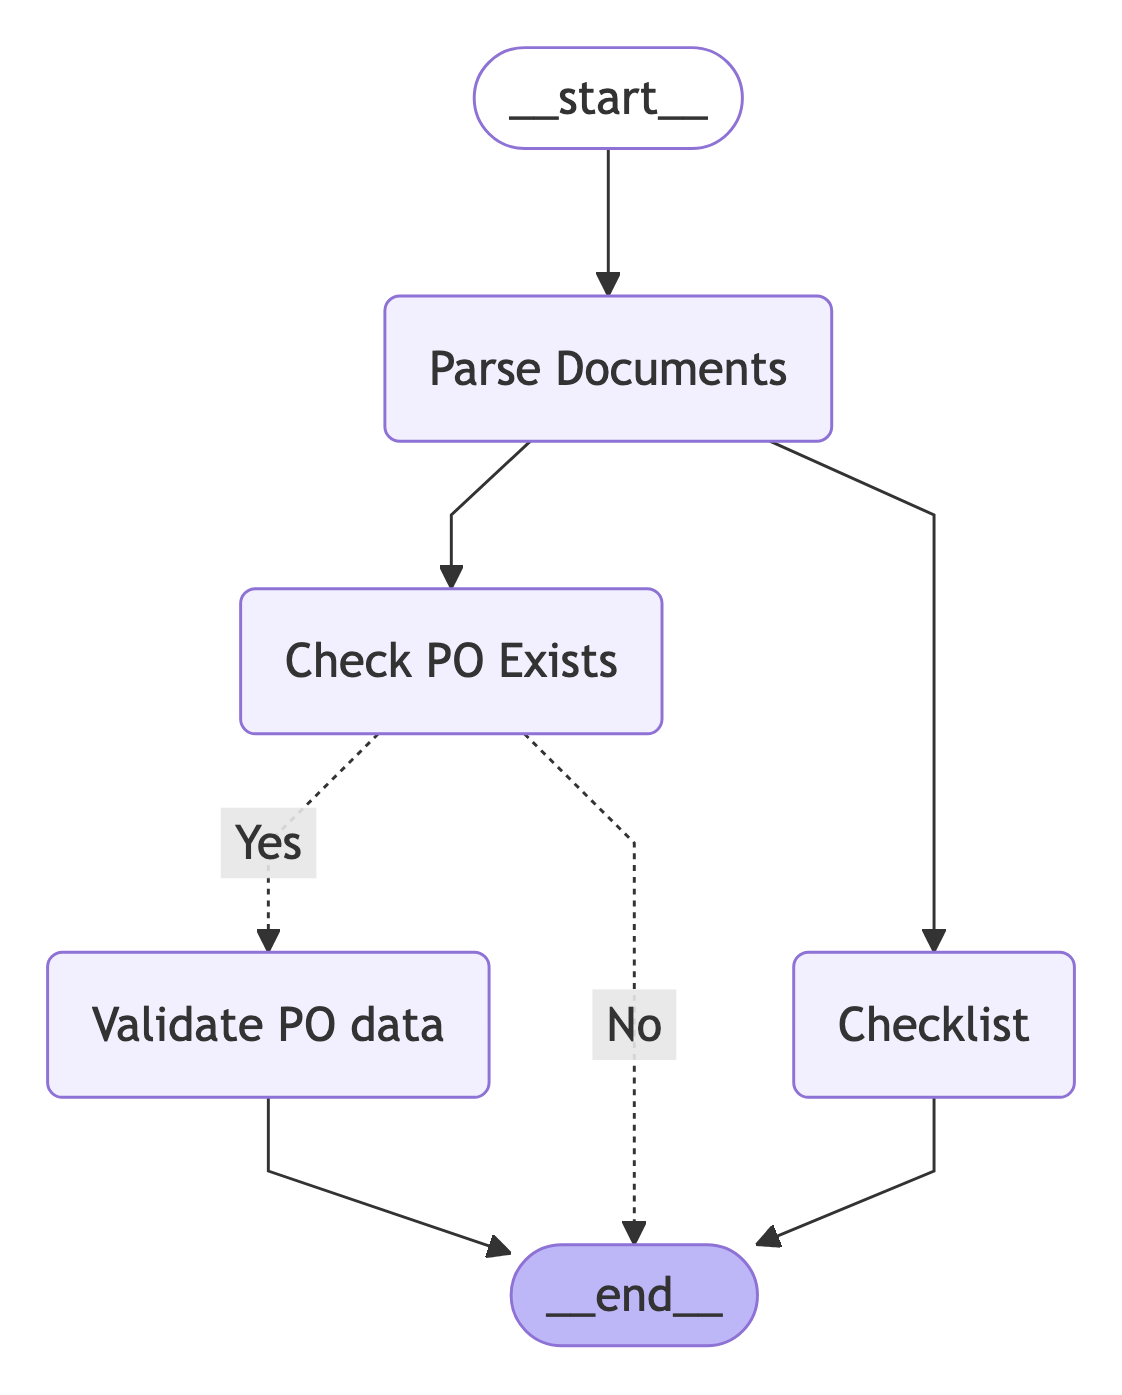

In [25]:
import nest_asyncio
nest_asyncio.apply()
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

app = build_graph()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER
        )
    )
)
